##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API を使用したオプティマイザ

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/core/optimizers_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## はじめに

このノートブックでは、[TensorFlow Core 低レベル API](https://www.tensorflow.org/guide/core) を使用してカスタムオプティマイザを作成する手順を紹介します。TensorFlow Core と意図するユースケースの詳細については、[Core API の概要](https://www.tensorflow.org/guide/core)を参照してください。

[Keras オプティマイザ](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)モジュールは、多くの一般的なトレーニングに推奨される最適化ツールキットです。これには、さまざまな事前構築済みオプティマイザと、カスタマイズ用のサブクラス化機能が含まれています。Keras オプティマイザは、Core API で構築されたカスタムレイヤー、モデル、およびトレーニングループとも互換性があります。これらの事前構築済みのカスタマイズ可能なオプティマイザは、ほとんどの場合に適していますが、Core API を使用すると、最適化プロセスを完全に制御できます。たとえば、Sharpness-Aware Minimization（SAM）などの手法では、モデルとオプティマイザを結合する必要があり、従来の機械学習オプティマイザの定義には適合しません。このガイドでは、Core API を使用してゼロからカスタムオプティマイザを構築するプロセスについて説明し、オプティマイザの構造、実装、および動作を完全に制御できるようにします。

## オプティマイザの概要

オプティマイザは、モデルのトレーニング可能なパラメータに関する損失関数を最小化するためのアルゴリズムです。最も簡単な最適化手法は勾配降下法です。これは、損失関数の最も降下する方向に進むことで、モデルのパラメータを繰り返し更新します。そのステップサイズは勾配のサイズに正比例するため、勾配が大きすぎたり小さすぎたりすると問題になる可能性があります。Adam、Adagrad、RMSprop など、メモリ効率と収束のスピードアップのために勾配のさまざまな数学的特性を活用する勾配ベースのオプティマイザは他にも多数あります。

## セットアップ

In [2]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [3]:
import tensorflow as tf
print(tf.__version__)
# set random seed for reproducible results 
tf.random.set_seed(22)

2024-01-11 19:02:46.984226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:02:46.984271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:02:46.985972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


## 勾配下降法

基本的なオプティマイザ クラスには、初期化メソッドと、勾配のリストが与えられた変数のリストを更新する関数が必要です。まず、学習率でスケーリングされた勾配を減算して各変数を更新する基本的な勾配降下オプティマイザを実装します。

In [4]:
class GradientDescent(tf.Module):

  def __init__(self, learning_rate=1e-3):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables
    for grad, var in zip(grads, vars):
      var.assign_sub(self.learning_rate*grad)

このオプティマイザをテストするには、サンプル損失関数を作成して、単一の変数 $x$ に関して最小化します。その勾配関数を計算し、最小化パラメータ値を解きます。

$$L = 2x^4 + 3x^3 + 2$$

$$\frac{dL}{dx} = 8x^3 + 9x^2$$

$\frac{dL}{dx}$ は、鞍点である $x = 0$ で 0 です。$x = - \frac{9}{8}$ は大域的最小値です。したがって、損失関数は $x^\star = - \frac{9}{8}$ で最適化されます。

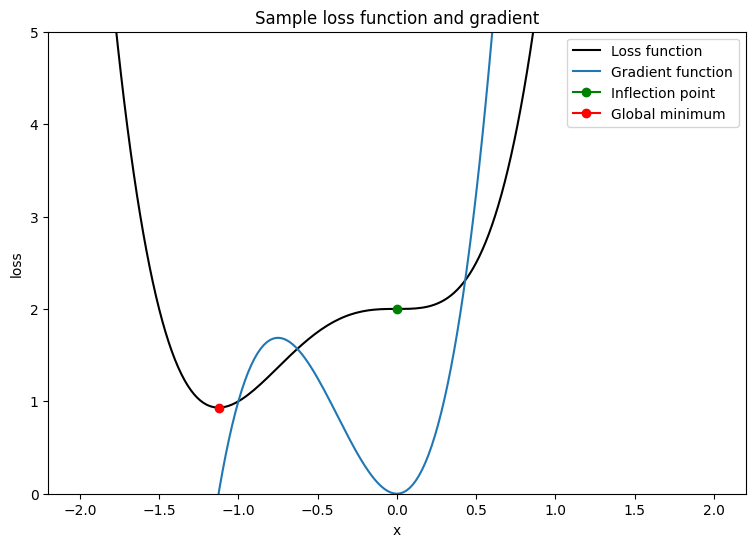

In [5]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)

def loss(x):
  return 2*(x**4) + 3*(x**3) + 2

def grad(f, x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    result = f(x)
  return tape.gradient(result, x)

plt.plot(x_vals, loss(x_vals), c='k', label = "Loss function")
plt.plot(x_vals, grad(loss, x_vals), c='tab:blue', label = "Gradient function")
plt.plot(0, loss(0),  marker="o", c='g', label = "Inflection point")
plt.plot(-9/8, loss(-9/8),  marker="o", c='r', label = "Global minimum")
plt.legend()
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("loss")
plt.title("Sample loss function and gradient");

単一の可変損失関数を使用してオプティマイザの収束をテストする関数を作成します。タイムステップ $t$ での更新されたパラメータの値が、タイムステップ $t-1$ で保持されている値と同じである場合、収束が達成されたと仮定します。設定された回数の反復後にテストを終了し、プロセス中に大きくなりすぎる勾配を追跡します。最適化アルゴリズムに本当に挑戦するには、パラメータの初期化を不十分にします。上記の例では、$x = 2$ が適切な選択です。勾配が急であり、変曲点にもつながるためです。

In [6]:
def convergence_test(optimizer, loss_fn, grad_fn=grad, init_val=2., max_iters=2000):
  # Function for optimizer convergence test
  print(optimizer.title)
  print("-------------------------------")
  # Initializing variables and structures
  x_star = tf.Variable(init_val)
  param_path = []
  converged = False

  for iter in range(1, max_iters + 1):
    x_grad = grad_fn(loss_fn, x_star)

    # Case for exploding gradient
    if tf.math.is_nan(x_grad):
      print(f"Gradient exploded at iteration {iter}\n")
      return []

    # Updating the variable and storing its old-version
    x_old = x_star.numpy()
    optimizer.apply_gradients([x_grad], [x_star])
    param_path.append(x_star.numpy())

    # Checking for convergence
    if x_star == x_old:
      print(f"Converged in {iter} iterations\n")
      converged = True
      break
      
  # Print early termination message
  if not converged:
    print(f"Exceeded maximum of {max_iters} iterations. Test terminated.\n")
  return param_path

次の学習率（1e-3、1e-2、1e-1）の勾配降下オプティマイザの収束をテストします。

In [7]:
param_map_gd = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_gd[learning_rate] = (convergence_test(
      GradientDescent(learning_rate=learning_rate), loss_fn=loss))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



損失関数の等高線図でパラメータのパスを可視化します。

In [8]:
def viz_paths(param_map, x_vals, loss_fn, title, max_iters=2000):
  # Creating a controur plot of the loss function
  t_vals = tf.range(1., max_iters + 100.)
  t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
  loss_grid = tf.math.log(loss_fn(x_grid))
  plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading='nearest')
  colors = ['r', 'w', 'c']
  # Plotting the parameter paths over the contour plot
  for i, learning_rate in enumerate(param_map):
    param_path = param_map[learning_rate]
    if len(param_path) > 0:
      x_star = param_path[-1]
      plt.plot(t_vals[:len(param_path)], param_path, c=colors[i])
      plt.plot(len(param_path), x_star, marker='o', c=colors[i], 
              label = f"x*: learning rate={learning_rate}")
  plt.xlabel("Iterations")
  plt.ylabel("Parameter value")
  plt.legend()
  plt.title(f"{title} parameter paths")

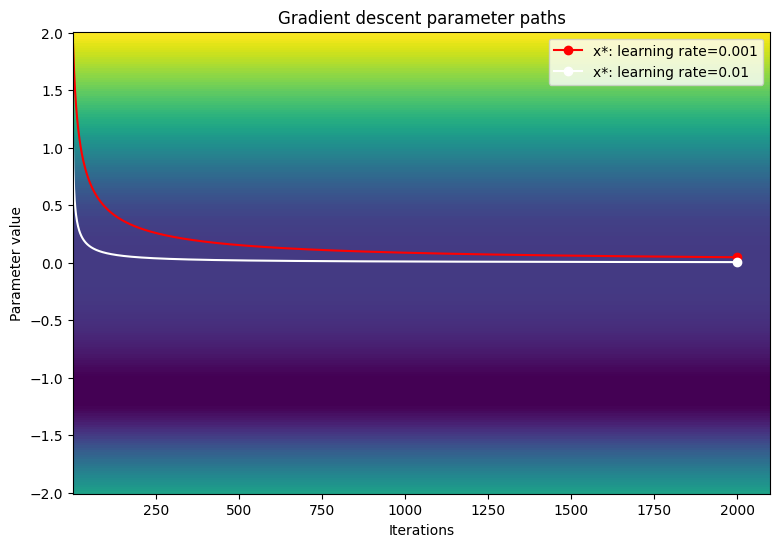

In [9]:
viz_paths(param_map_gd, x_vals, loss, "Gradient descent")

小さい学習率を使用すると勾配降下は変曲点で動けなくなるようです。学習率を上げると、ステップサイズが大きくなるため、プラトー領域での動きが速くなります。ただし、これには、損失関数が非常に急勾配である場合、初期の反復で大きすぎる勾配が発生するリスクがあります。

## モメンタムパラメータ付き勾配降下法

モメンタムパラメータ付き勾配降下法では、勾配を使用して変数を更新するだけでなく、前回の更新に基づいて変数の位置を変更します。 モメンタムは、タイムステップ $t-1$ での更新がタイムステップ $t$ での更新に与える影響のレベルを決定します。モメンタムを増やすと、基本的な勾配降下法よりも速くプラトー領域を越えて変数を移動できます。モメンタムパラメータの更新ルールは次のとおりです。

$$\Delta_x^{[t]} = lr \cdot L^\prime(x^{[t]}) + p \cdot \Delta_x^{[t-1]}$$

$$x^{[t]} = x^{[t-1]} - \Delta_x^{[t]}$$

ここでは、それぞれ以下を意味します。

- $x$: 最適化される変数
- $\Delta_x$: $x$ の変更
- $lr$: 学習率
- $L^\prime(x)$: x に関する損失関数の勾配
- $p$: モメンタムパラメータ

In [10]:
class Momentum(tf.Module):

  def __init__(self, learning_rate=1e-3, momentum=0.7):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.change = 0.
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables 
    for grad, var in zip(grads, vars):
      curr_change = self.learning_rate*grad + self.momentum*self.change
      var.assign_sub(curr_change)
      self.change = curr_change

次の学習率（1e-3、1e-2、1e-1）のモメンタムオプティマイザの収束をテストします。

In [11]:
param_map_mtm = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_mtm[learning_rate] = (convergence_test(
      Momentum(learning_rate=learning_rate),
      loss_fn=loss, grad_fn=grad))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Converged in 80 iterations

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



損失関数の等高線図でパラメータのパスを可視化します。

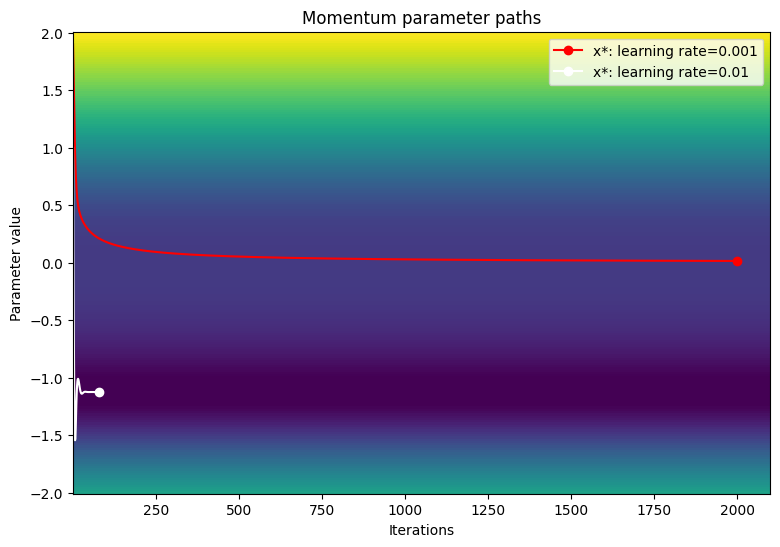

In [12]:
viz_paths(param_map_mtm, x_vals, loss, "Momentum")

## 適応モーメント推定 (Adam)

適応モーメント推定（Adam）アルゴリズムは、効率的で高度に一般化可能な最適化手法であり、2 つの重要な勾配降下法（モメンタムと二乗平均平方根（RMSP））を活用します。モメンタムは、減衰パラメータと共に最初のモーメント（勾配の合計）を使用することにより、勾配降下を加速するのに役立ちます。RMSP も同様ですが、二次モーメント（勾配の 2 乗の合計）を利用します。

Adam アルゴリズムは、一次モーメントと二次モーメントの両方を組み合わせて、より一般化可能な更新規則を提供します。変数 $x$ の符号は、$\frac{x}{\sqrt{x^2}}$ を計算することによって決定できます。Adam オプティマイザは、この事実を使用して、効果的に平滑化された符号である更新ステップを計算します。 $\frac{x}{\sqrt{x^2}}$ を計算する代わりに、オプティマイザは変数の更新ごとに $x$ （一次モーメント）と $x^2$ （二次モーメント）の平滑化バージョンを計算します。


**Adam アルゴリズム**

$\beta_1 \gets 0.9 ; \triangleright \text{literature value}$

$\beta_2 \gets 0.999 ; \triangleright \text{literature value}$

$lr \gets \text{1e-3} ; \triangleright \text{configurable learning rate}$

$\epsilon \gets \text{1e-7} ; \triangleright \text{prevents divide by 0 error}$

$V_{dv} \gets \vec {\underset{n\times1}{0}} ;\triangleright \text{stores momentum updates for each variable}$

$S_{dv} \gets \vec {\underset{n\times1}{0}} ; \triangleright \text{stores RMSP updates for each variable}$

$t \gets 1$

$\text{On iteration } t:$

$;;;; \text{For} (\frac{dL}{dv}, v) \text{ in gradient variable pairs}:$

$;;;;;;;; V_{dv_i} = \beta_1V_{dv_i} + (1 - \beta_1)\frac{dL}{dv} ; \triangleright \text{momentum update}$

$;;;;;;;; S_{dv_i} = \beta_2V_{dv_i} + (1 - \beta_2)(\frac{dL}{dv})^2 ; \triangleright \text{RMSP update}$

$;;;;;;;; v_{dv}^{bc} = \frac{V_{dv_i}}{(1-\beta_1)^t} ; \triangleright \text{momentum bias correction}$

$;;;;;;;; s_{dv}^{bc} = \frac{S_{dv_i}}{(1-\beta_2)^t} ; \triangleright \text{RMSP bias correction}$

$;;;;;;;; v = v - lr\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon} ; \triangleright \text{parameter update}$

$;;;;;;;; t = t + 1$

**アルゴリズム終了**

$V_{dv}$ と $S_{dv}$ が 0 に初期化され、$\beta_1$ と $\beta_2$ が 1 に近い場合、モメンタムと RMSP の更新は自然に 0 に偏ります。したがって、変数にはバイアス補正が役立ちます。バイアス補正は、重みが大域的最小値に近づくにつれて、重みの振動を制御するのにも役立ちます。

In [13]:
class Adam(tf.Module):
  
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads, vars):
      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
        # Bias correction
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        # Update model variables
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      # Increment the iteration counter
      self.t += 1.

勾配降下の例と同じ学習率で Adam オプティマイザのパフォーマンスをテストします。 

In [14]:
param_map_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_adam[learning_rate] = (convergence_test(
      Adam(learning_rate=learning_rate), loss_fn=loss))

Adam: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.1
-------------------------------


Converged in 1156 iterations



損失関数の等高線図でパラメータのパスを可視化します。

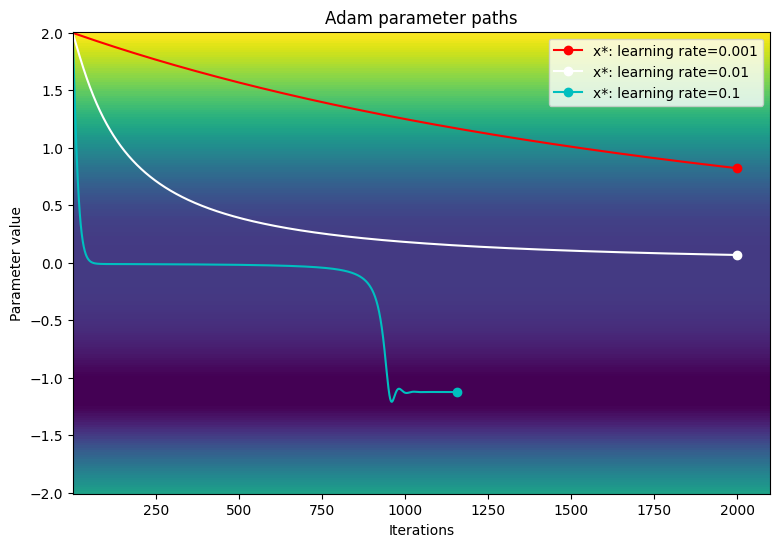

In [15]:
viz_paths(param_map_adam, x_vals, loss, "Adam")

この特定の例では、小さい学習率を使用すると、Adam オプティマイザは従来の勾配降下法と比較して収束が遅くなります。ただし、学習率が大きくなるとアルゴリズムは正常にプラトー領域を通過し、大域的最小値に収束します。大きな勾配に遭遇した場合は、学習率の動的スケーリングにより、勾配が大きくなりすぎることはありません。

## まとめ

このノートブックでは、オプティマイザの記述の基本と [TensorFlow Core API](https://www.tensorflow.org/guide/core) との比較を紹介しました。Adam のような事前構築されたオプティマイザは一般化可能ですが、すべてのモデルまたはデータセットに対して常に最適な選択であるとは限りません。最適化プロセスをきめ細かく制御することで、ML トレーニングワークフローを合理化し、全体的なパフォーマンスを向上させることができます。カスタムオプティマイザのその他の例については、次のドキュメントを参照してください。

- この Adam オプティマイザは、[多層パーセプトロン](https://www.tensorflow.org/guide/core/mlp_core)のチュートリアルと[分散トレーニング]()で使用されています。
- [Model Garden](https://blog.tensorflow.org/2020/03/introducing-model-garden-for-tensorflow-2.html) には、Core API で記述されたさまざまな[カスタムオプティマイザ](https://github.com/tensorflow/models/tree/master/official/modeling/optimization)があります。
